In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: Lectures 14 and 15

**Due date: Check the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html)**

## Imports <a name="im"></a>

In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, fcluster

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Instructions
rubric={points}

You will earn points for following these instructions and successfully submitting your work on Gradescope.  

### Group wotk instructions

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2.
  
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


### General submission instructions

- Please **read carefully
[Use of Generative AI policy](https://ubc-cs.github.io/cpsc330-2025W1/syllabus.html#use-of-generative-ai-in-the-course)** before starting the homework assignment. 
- **Run all cells before submitting:** Go to `Kernel -> Restart Kernel and Clear All Outputs`, then select `Run -> Run All Cells`. This ensures your notebook runs cleanly from start to finish without errors.
  
- **Submit your files on Gradescope.**  
   - Upload only your `.ipynb` file **with outputs displayed** and any required output files.
     
   - Do **not** submit other files from your repository.  
   - If you need help, see the [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/).  
- **Check that outputs render properly.**  
   - Make sure all plots and outputs appear in your submission.
     
   - If your `.ipynb` file is too large and doesn't render on Gradescope, also upload a PDF or HTML version so the TAs can view your work.  
- **Keep execution order clean.**  
   - Execution numbers must start at "1" and increase in order.
     
   - Notebooks without visible outputs may not be graded.  
   - Out-of-order or missing execution numbers may result in mark deductions.  
- **Follow course submission guidelines:** Review the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html) for detailed guidance on completing and submitting assignments. 
   
</div>

_Points:_ 4

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise you will cluster sentences from a toy corpus. Later in the homework you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [3]:
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/lizapatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lizapatel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import wikipedia
import string
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "Artificial Intelligence",
    "Deep learning",
    "Unsupervised learning",
    "Quantum Computing",
    "Environmental protection",
    "Climate Change",
    "Renewable Energy",
    "Biodiversity",
    "French Cuisine",
    "Bread food",
    "Dumpling food",
]
wiki_dict = {"wiki query": [], "text": [], "n_words": []}
remove_tokens = list(string.punctuation) + ['``', '’', '`', 'br', '"', "”", "''", "'s", "(", ")", "[", "]"]

# Running this code might take some time.
for query in queries:
    try:
        # Attempt to fetch the page content
        page_content = wikipedia.page(query).content
    except wikipedia.exceptions.PageError:
        print(f"Page not found for query: {query}. Skipping...")
        continue
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Query: {query} led to a disambiguation page. Choosing the first option: {e.options[0]}")
        page_content = wikipedia.page(e.options[0]).content

    text = sent_tokenize(page_content)[0]
    tokenized = word_tokenize(text)
    text_pp = [token.lower() for token in tokenized if token.lower() not in remove_tokens]
    wiki_dict["n_words"].append(len(text_pp))
    wiki_dict["text"].append(" ".join(text_pp))
    wiki_dict["wiki query"].append(query)

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20
7,Biodiversity,biodiversity is the variability of life on earth,8
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10
9,Bread food,bread is a baked food product made from water flour and often yeast,13


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={reasoning}

<div class="alert alert-info">

**Your tasks:**

- If tasked with manually clustering documents from this toy corpus, how many clusters would you identify, and what labels would you assign to each cluster?
</div>

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

I could come up with three clusters. I would label them as technical, food and geological.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 K-Means with bag-of-words representation 
rubric={accuracy}

In the lecture, we explored how **data representation significantly impacts clustering quality**. We saw that replacing a **flattened image representation** with feature vectors extracted from **pre-trained models** greatly improved clustering results.  

What about text data? In previous machine learning courses, we have used the **bag-of-words (BoW) representation** to numerically encode text, where each document is represented with a vector of word frequencies. 

In this exercise, you will **cluster documents** using this **simplistic text representation**.  

<div class="alert alert-info">

**Your tasks:**

1. Use [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with its **default settings** to transform the `text` column in `wiki_df` into a numerical representation.  

2. Use [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to cluster the encoded documents and store the cluster labels in `kmeans_bow_labels`.  
   - Set `random_state=42` for **reproducibility**.
     
   - Use the **number of clusters** (`n_clusters`) identified in the **previous exercise**.  
</div>

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 2

In [5]:
vectorizer = CountVectorizer()
data = vectorizer.fit_transform(wiki_df['text']).toarray()
feature_names = vectorizer.get_feature_names_out()
data_df = pd.DataFrame(data, columns=feature_names)
wiki_df = pd.concat([wiki_df, data_df], axis=1)


In [6]:
wiki_df

,wiki query,text,n_words,ai,algorithm,also,an,and,are,armenian,...,utilizing,variability,warming,water,way,west,where,wider,with,yeast
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37,0,0,0,1,2,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,Biodiversity,biodiversity is the variability of life on earth,8,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Bread food,bread is a baked food product made from water flour and often yeast,13,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [7]:
model = KMeans(n_clusters=3, random_state=42).fit(data_df)
kmeans_bow_labels = model.predict(data_df)
kmeans_bow_labels

array([1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [8]:
wiki_df["bow_kmeans"] = kmeans_bow_labels
wiki_df

,wiki query,text,n_words,ai,algorithm,also,an,and,are,armenian,...,variability,warming,water,way,west,where,wider,with,yeast,bow_kmeans
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37,0,0,0,1,2,0,0,...,0,0,0,1,0,0,0,0,0,1
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
7,Biodiversity,biodiversity is the variability of life on earth,8,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Bread food,bread is a baked food product made from water flour and often yeast,13,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 K-Means with sentence embedding representation
rubric={accuracy}

In the previous exercise, you may have noticed that clustering results were suboptimal. While the bag-of-words (BoW) representation is useful, it has significant limitations. It does not capture word order or context effectively.  

To improve text representation, we can use pre-trained models, similar to those used for image data, to extract richer, context-aware embeddings through transfer learning. In this lab, we will use the **pre-trained model** `'all-MiniLM-L6-v2'`, available via the [Sentence Transformers](https://www.sbert.net/index.html) package.  

This deep learning model generates **dense, fixed-length vector representations** of sentences, capturing **semantic meaning and contextual information**. These representations are particularly effective for **clustering and semantic similarity tasks**. If you're interested in exploring more **pre-trained models**, refer to the [full list here](https://www.sbert.net/docs/pretrained_models.html). We will explore these representations further in **DSCI 575**.  

<div class="alert alert-info">

**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus.
   
3. Apply `KMeans` to the **sentence embeddings** (`emb_sents`) and store the cluster labels in `kmeans_emb_labels`. Use the following parameters:  
    - `random_state=42` (for reproducibility)
      
    - `n_clusters`=the number of clusters you identified in 1.1

Note
- The code below might throw a warning. You may ignore it for the purpose of this lab. 
</div>

In [9]:
!{sys.executable} -m pip install sentence-transformers


/bin/bash: {sys.executable}: command not found


In [10]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [11]:
emb_sents = embedder.encode(wiki_df["text"].tolist())
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.005857,-0.004795,-0.000976,0.011121,0.005294,-0.061630,0.062072,0.033673,-0.035251,0.074072,...,0.088312,-0.006600,0.036511,-0.020797,-0.002082,0.058263,0.061880,0.097383,0.058155,-0.052016
1,-0.124845,-0.084891,0.082492,0.017458,0.022980,0.056852,-0.060654,-0.060344,-0.020284,-0.070915,...,0.082265,0.009324,-0.005930,-0.130974,0.002398,0.052424,-0.008989,0.015588,-0.017661,-0.018494
2,-0.056721,-0.049697,-0.014780,0.022572,0.051773,0.007456,0.008632,-0.074847,-0.065573,-0.027284,...,0.014761,-0.022392,0.021360,-0.107016,0.020530,0.045678,0.052755,0.005429,0.022018,-0.010994
3,-0.072006,0.006120,-0.085242,0.051515,-0.119036,0.015745,-0.006809,-0.064673,0.004276,0.018435,...,-0.067665,0.031661,-0.017610,-0.072480,-0.008318,0.127195,0.033353,0.084555,0.015101,0.020704
4,-0.012700,0.101830,0.066676,-0.007987,0.140040,0.041627,0.035495,-0.050723,-0.037633,0.055886,...,-0.042105,-0.038883,0.018268,0.009920,0.028208,0.052759,-0.009605,-0.004518,0.060853,0.057709
5,-0.014444,0.022869,0.145982,0.054865,0.085204,-0.014689,-0.102757,0.016853,-0.023799,0.021148,...,0.011778,0.016817,-0.020041,0.006375,0.055428,0.076868,-0.047152,-0.114797,-0.056382,0.022349
6,-0.044869,0.076882,-0.012749,0.033335,0.067894,-0.002327,0.031620,-0.021576,0.046619,0.005089,...,-0.021575,-0.017596,-0.069995,0.004461,-0.040409,-0.043067,0.044042,-0.050977,0.056506,0.048708
7,0.027806,0.077117,0.015402,-0.013544,0.043216,0.048124,0.027763,-0.022999,0.049303,0.009686,...,0.014946,-0.020896,0.022283,-0.012311,0.014079,0.028085,0.025272,-0.015233,-0.014879,-0.064280
8,0.026616,-0.019929,-0.008049,-0.025907,-0.055372,0.011235,-0.024538,-0.065724,0.058374,-0.062895,...,-0.059513,0.077446,-0.059827,-0.021454,0.088102,-0.127180,-0.031399,0.120572,0.072373,-0.058336
9,-0.014786,0.055887,-0.020880,0.005313,-0.025037,0.040478,0.035260,0.024938,0.017546,0.072433,...,-0.082098,0.037856,-0.020007,-0.087252,0.058163,-0.044187,-0.030253,-0.080385,0.075614,-0.070403


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 2

In [12]:
model = KMeans(n_clusters=3, random_state=42).fit(data_df)

In [13]:
kmeans_emb_labels = model.predict(data_df)

In [14]:
wiki_df["emb_kmeans"] = kmeans_emb_labels
wiki_df

,wiki query,text,n_words,ai,algorithm,also,an,and,are,armenian,...,warming,water,way,west,where,wider,with,yeast,bow_kmeans,emb_kmeans
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,2,2
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37,0,0,0,1,2,0,0,...,0,0,1,0,0,0,0,0,1,1
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,1
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,Biodiversity,biodiversity is the variability of life on earth,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
9,Bread food,bread is a baked food product made from water flour and often yeast,13,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with sentence embedding representation and cosine distance  
rubric={accuracy}

Now, let's apply [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) to our toy dataset.  

Unlike K-Means, which relies on Euclidean distance due to its use of centroids, DBSCAN allows us to experiment with different distance metrics. For text data, [**cosine similarity**](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) (or its complement, **cosine distance**) is often more effective than Euclidean distance.  

The **cosine distance** between two vectors $u$ and $v$ is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

<div class="alert alert-info">

**Your tasks:**

- Apply **DBSCAN** to cluster documents encoded with **sentence embeddings** (`emb_sents`) and store the cluster labels in `dbscan_emb_labels`.
    
- Set `metric='cosine'` to use **cosine distance** for clustering.
- Tune the **hyperparameters** `eps` and `min_samples` to obtain meaningful clusters, as the default values are unlikely to work well on this dataset.  

**Notes for tuning the hyperparameters:**

- Start by examining the minimum, maximum, and mean cosine distances in the dataset. You can compute pairwise cosine distances using the package imported below.
  
- Experiment with a range of `eps` values and print the number of clusters and their sizes for each value.
- Select the `eps` value that produces the desired number of clusters.


</div>

In [15]:
from sklearn.metrics.pairwise import cosine_distances

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [16]:
dbscan = DBSCAN(metric='cosine')
dbscan.fit(emb_sents)
dbscan_emb_labels = dbscan.labels_
dbscan_emb_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [17]:
D = cosine_distances(emb_sents)
np.percentile(D, [1, 10, 25, 50, 75, 90, 99])

array([0.        , 0.50285655, 0.74596941, 0.92573428, 0.97952771,
       0.99968827, 1.03393722])

In [18]:
param_grid = {'eps' : np.arange(0.5, 1.2, 0.05),
            'min_samples' : [2, 3, 5, 7] }

results = {'eps': [],
           'min_samples': [],
          'labels': []}

for eps in param_grid['eps']: 
    for min_samples in param_grid['min_samples']:
        dbscan = DBSCAN(metric='cosine', eps=eps, min_samples= min_samples)
        dbscan.fit(emb_sents)
        results['eps'].append(eps)
        results['min_samples'].append(min_samples)
        results['labels'].append(dbscan.labels_)
    
results = pd.DataFrame(results)
results['num_labels'] = results['labels'].apply(lambda x: len(np.unique(x)))
results = results.sort_values(by='num_labels', ascending=False)
results

dbscan = DBSCAN(metric='cosine', eps=0.85, min_samples=2)
dbscan.fit(emb_sents)
dbscan_emb_labels = dbscan.labels_

In [19]:
wiki_df["emb_dbscan"] = dbscan_emb_labels
wiki_df

,wiki query,text,n_words,ai,algorithm,also,an,and,are,armenian,...,water,way,west,where,wider,with,yeast,bow_kmeans,emb_kmeans,emb_dbscan
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,0
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2,2,0
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,2,2,0
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37,0,0,0,1,2,0,0,...,0,1,0,0,0,0,0,1,1,0
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,1
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
7,Biodiversity,biodiversity is the variability of life on earth,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,2
9,Bread food,bread is a baked food product made from water flour and often yeast,13,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,1,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Hierarchical clustering with sentence embedding representation
rubric={accuracy}

<div class="alert alert-info">

**Your tasks:**

Apply hierarchical clustering on `emb_sents`. In particular
1. Create and show a dendrogram with `complete` linkage and `metric='cosine'` on this toy dataset.

3. Create flat clusters using `fcluster` with appropriate hyperparameters and store cluster labels to `hier_emb_labels` variable below.

</div>

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 3

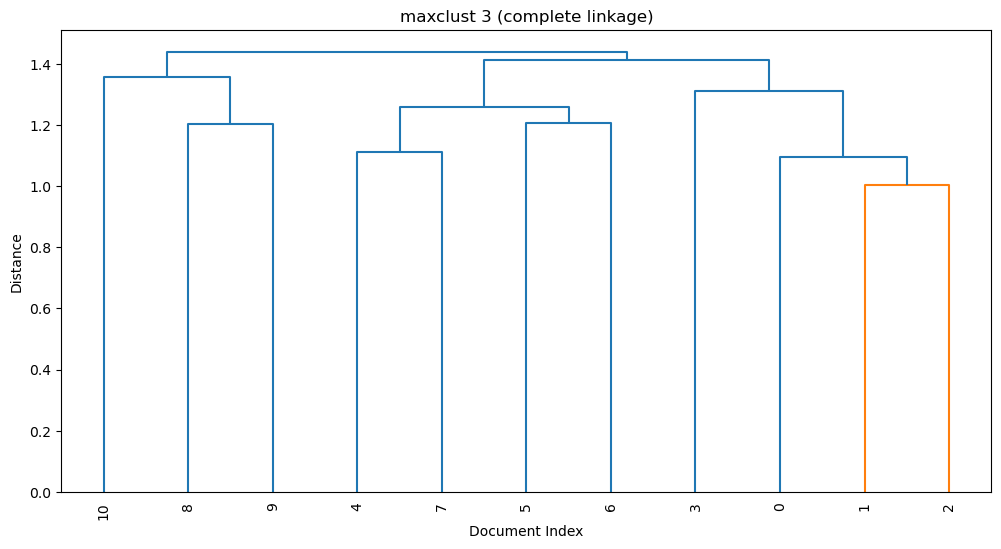

In [20]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

linkage_array = complete(emb_sents)

max_clusters = 3
hier_emb_labels = fcluster(linkage_array, t=max_clusters, criterion='maxclust')

def plot_dendrogram_clusters(X, linkage_matrix, labels, linkage_type='complete', title="Dendrogram"):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10, color_threshold=None)
    plt.title(title + f" ({linkage_type} linkage)")
    plt.xlabel("Document Index")
    plt.ylabel("Distance")
    plt.show()

plot_dendrogram_clusters(emb_sents, linkage_array, hier_emb_labels, linkage_type='complete', title=f"maxclust {max_clusters}")


In [21]:
hier_emb_labels = fcluster(linkage_array, t=max_clusters, criterion='maxclust')
hier_emb_labels 

array([3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1], dtype=int32)

In [22]:
wiki_df["emb_hierarchical"] = hier_emb_labels
wiki_df

,wiki query,text,n_words,ai,algorithm,also,an,and,are,armenian,...,way,west,where,wider,with,yeast,bow_kmeans,emb_kmeans,emb_dbscan,emb_hierarchical
0,Artificial Intelligence,artificial intelligence ai is the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problem-solving perception and decision-making,25,1,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,3
1,Deep learning,in machine learning deep learning focuses on utilizing multilayered neural networks to perform tasks such as classification regression and representation learning,21,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,0,3
2,Unsupervised learning,in machine learning supervised learning sl is a type of machine learning paradigm where an algorithm learns to map input data to a specific output based on example input-output pairs,30,0,1,0,1,0,0,0,...,0,0,1,0,0,0,2,2,0,3
3,Quantum Computing,a quantum computer is a real or theoretical computer that uses quantum mechanical phenomena in an essential way it exploits superposed and entangled states and the intrinsically non-deterministic outcomes of quantum measurements as features of its computation,37,0,0,0,1,2,0,0,...,1,0,0,0,0,0,1,1,0,3
4,Environmental protection,environmental protection or environment protection refers to the taking of measures to protecting the natural environment prevent pollution and maintain ecological balance,22,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,2
5,Climate Change,present-day climate change includes both global warming—the ongoing increase in global average temperature—and its wider effects on earth climate system,20,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,1,2
6,Renewable Energy,renewable energy also called green energy is energy made from renewable natural resources that are replenished on a human timescale,20,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,1,2
7,Biodiversity,biodiversity is the variability of life on earth,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,2
8,French Cuisine,french cuisine is the cooking traditions and practices of france,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,2,1
9,Bread food,bread is a baked food product made from water flour and often yeast,13,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,2,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Discussion
rubric={reasoning}

<div class="alert alert-info">

**Your tasks:**

Reflect on and discuss the clustering results of the methods you explored in the previous exercises, focusing on the following points:    
- effect of input representation on clustering results

- whether the clustering results match with your intuitions and the challenges associated with getting the desired clustering results with each method

</div>

<div class="alert alert-warning">

Solution_1.6
    
</div>

_Points:_ 4

The way the documents are represented with embeddings has a big impact on clustering because it defines what counts as similar, so if the embeddings are not very clear, the clusters can be messy. Kmeans could not capture similarities in the way which I wanted. DBSCAN was tricky to use at first since most points ended up as noise or in one big cluster until I tuned eps and min_samples. Hierarchical clustering gave a nice dendrogram and let me control the number of clusters with fcluster, making it very easy. I think that the clusters made sense only when the embeddings captured meaningful differences between the documents. I think that all 3 algorithms take into account the shape of the data but since they use different methods to cluster the data, they give varying quality of results. THe clustering results do match with my intuition and reflect what I had anwered in question 1.1 too for each method.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.7 Visualizing clusters
rubric={points:4}


One approach to working with unlabeled data is visualization. That said, our data is high-dimensional, making it challenging to visualize. Take sentence embedding representation as an example: each instance is depicted in 768 dimensions. To visualize such high-dimensional data, we can employ dimensionality reduction techniques to extract the most significant 2 or 3 components, and then visualize this low-dimensional data.

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```
or

```
> conda activate cpsc330
> pip install umap-learn 
```

If you get an error with the import below try

```
pip install --upgrade numba umap-learn
```

<div class="alert alert-info">
    
**Your tasks:**

1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
    - K-Means with bag-of-words representation 
    - K-Means with sentence embedding representation
    - DBSCAN with sentence embedding representation 
    - Flat cluster of hierarchical clustering with sentence embedding representation
</div>

In [23]:
%pip install umap-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import umap

In [ ]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_texts=None,
    show_labels=False,
    point_size=50,
    n_neighbors=15,
    title="UMAP Visualization",
    ignore_noise=False,
):
    """
    Perform dimensionality reduction using UMAP and visualize the resulting clusters.

    Parameters
    ----------
    data : np.ndarray
        Feature matrix to be reduced.
    cluster_labels : array-like
        Cluster label for each data point.
    raw_texts : list of str, optional
        Original texts corresponding to the data points (used when show_labels=True).
    show_labels : bool, default=False
        Whether to annotate points with text labels.
    point_size : int, default=50
        Size of the scatterplot points.
    n_neighbors : int, default=15
        Number of neighbors used in UMAP.
    title : str, default="UMAP Visualization"
        Title of the plot.
    ignore_noise : bool, default=False
        Whether to exclude points labeled as noise (-1).

    Returns
    -------
    None
    """
    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    embedding = reducer.fit_transform(data)

    df = pd.DataFrame(embedding, columns=["dim1", "dim2"])
    df["cluster"] = cluster_labels

    if ignore_noise:
        df = df[df["cluster"] != -1]

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        df["dim1"], df["dim2"],
        c=df["cluster"], cmap="tab20b", s=point_size
    )

    ax.legend(*scatter.legend_elements(), title="Clusters", loc="best")

    if show_labels and raw_texts is not None:
        for (x, y, text) in zip(df["dim1"], df["dim2"], raw_texts):
            ax.annotate(" ".join(text.split()[:10]), (x, y), fontsize=8)

    plt.show()


In [ ]:
plot_umap_clusters(data=data_df, cluster_labels=kmeans_bow_labels, title="K-Means Clusters (BOW)")
plot_umap_clusters(data=emb_sents, cluster_labels=kmeans_emb_labels, title="K-Means Clusters (Sentence Embeddings)")
plot_umap_clusters(data=emb_sents, cluster_labels=dbscan_emb_labels, ignore_noise=True, title="DBSCAN Clusters (Sentence Embeddings)")
plot_umap_clusters(data=emb_sents, cluster_labels=hier_emb_labels, title="Hierarchical Clusters (Sentence Embeddings)")


<div class="alert alert-warning">

Solution_1.7
    
</div>

_Points:_ 4

In [ ]:
...

<!-- END QUESTION -->

<br><br><br><br>

Exercise 2: Food.com recipes


Now that we have applied document clustering on a toy corpus, let's move to a more realistic corpus.

In the lecture, we worked on an activity of manually clustering food items and discussed challenges associated with it. We also applied different clustering algorithms to cluster food images. We'll continue this theme of clustering food items in this lab. But instead of images we will cluster textual description of food items, i.e., recipe names.

In this assignment, we will work with a sample of Kaggle's Food.com recipes corpus. This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and not on reviews. The recipes are present in RAW_recipes.csv. Our goal is to find categories or groupings of recipes from this corpus based on their names.

Your tasks:

Download RAW_recipes.csv and put it under the data directory in the homework folder.
Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function get_recipes_sample below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags.
Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for n_tags. If you decide to go with a different value of n_tags, state it clearly in Exercise 2.1 so that the grader knows about it.

In [ ]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

In [ ]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [ ]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

In [ ]:
recipes_df["name"]

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 2.1 Longest and shorter recipe names 
rubric={points:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** of them in `shortest_recipe` and/or `longest_recipe` as a **string**.

</div>

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [ ]:
recipes_df['length'] = recipes_df['name'].apply(lambda x: len(x))
recipes_df = recipes_df.sort_values(by='length')


shortest_recipe = recipes_df.iloc[1]['name']
longest_recipe = recipes_df.iloc[-1]['name']

print(shortest_recipe)
print(longest_recipe)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment.
```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

</div>

In [ ]:
import sys
!"{sys.executable}" -m pip install wordcloud


<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

In [ ]:
from wordcloud import WordCloud


In [ ]:
text = " ".join(recipes_df['name'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)


plt.imshow(wordcloud)
plt.show()


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">

### 2.3 Representing recipe names
rubric={points:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.


> You might have to convert the recipe names to a list (`recipes_df["name"].tolist()`) for the embedder to work
> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> **This might take a while to run.**

</div>

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [ ]:
recipe_names = recipes_df['name'].dropna().astype(str).tolist()
model = SentenceTransformer('all-MiniLM-L6-v2')
emb_recipes = model.encode(recipe_names, show_progress_bar=True)
emb_recipes_df = pd.DataFrame(emb_recipes, index=recipes_df.dropna(subset=['name']).index)

In [ ]:
emb_recipes_df

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 3: Clustering recipe names
<hr>

In this exercise you'll cluster recipe names with some of the clustering algorithms we have seen in class. This will also involve making some attempts to pick reasonable hyperparameter values for each clustering method based on the quality of the resulting clusters. For example, for KMeans, you need to specify the number of clusters in advance, which is often challenging on real-world datasets. For DBSCAN, you need to pick appropriate `eps` and `min_samples`. For hierarchical clustering, you need to pick a suitable linkage criterion, distance metric, and prune the tree so that it's possible to visualize and interpret it. 

Here are some methods which may help you with picking reasonable values for the hyperparameters. 
- Visualize the Elbow plot (KMeans). 
- Visualize Silhouette plots. 
- Visualize resulting clusters using `plot_umap_clusters` function from Exercise 1. 
- Sample some recipes from each cluster, manually inspect whether there are coherent semantic themes. (For this, you may use the function `print_clusters` given below.) 
        
> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot and the Silhouette plots. You can intall it with

```conda install -c districtdatalabs yellowbrick```

**Note that the process of picking reasonable hyperparameter values will be exploratory, iterative, and will involve manual inspection and judgment, as there is no ground truth to verify how well the model is doing. In your solutions, please do not include everything you try. Only present the results of the most informative trials. Add a narrative to your answer so that it's easy for the grader to follow your choices and reasoning.** 

In [ ]:
def print_clusters(recipes_df, cluster_labels, n_recipes=10, replace=False, random_state=None):
    """
    Given recipes_df containing recipe names and cluster assignment (labels), 
    sample and print n_recipes recipes per cluster. 

    Parameters
    -----------
    recipe_df : pandas dataframe 
        recipes dataframe containing recipe names in the "name" column
    cluster_labels : ndarray or a list
        cluster labels for each row in recipes_df 
    n_recipes : int
        number of examples to sample from each cluster
    replace: bool
        replace flag to pass to the sampling of recipe names

    Returns
    -----------
    None
    """    
    
    grouped = (
        pd.DataFrame(
            {
                "name": recipes_df["name"],
                "cluster_label": cluster_labels,
            }
        )
        .sort_values("cluster_label")
        .groupby("cluster_label")    
    )
    
    for name, group in grouped:
        print(f"Cluster {name}")        
        print(("----------").format(""))        
        print("\n".join(group.sample(n_recipes, random_state=random_state, replace=replace)['name'].tolist()))
        print("\n\n")

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.1 K-Means
rubric={points:6}

**Your tasks:**

1. Cluster recipe titles using KMeans. Make some attempts to determine the optimal number of clusters. 
2. Pick one or two best models and justify your choice.

</div>

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 6

From the wordcloud I identified five clusters that looked common. They included cookie, salad, cake, chicken and foods with lemon. Due to this I decided to go with 5 clusters for my model. Using the function provided to us I can see that the classification for that model is working as I have clusters for recipes related to all the above clusters I identified manually.

In [ ]:
param_grid = {'n_clusters' : np.arange(1,20,1)}

results = {'n_clusters': [],
          'labels': []}

for n in param_grid['n_clusters']: 
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(emb_recipes_df)
    results['n_clusters'].append(n)
    results['labels'].append(kmeans.labels_)
    
results = pd.DataFrame(results)
results['num_labels'] = results['labels'].apply(lambda x: len(np.unique(x)))
results = results.sort_values(by='num_labels')
results

In [ ]:
kmeans_best = KMeans(n_clusters=5, random_state=42)
kmeans_best.fit(emb_recipes_df)
print_clusters(recipes_df, kmeans_best.labels_, n_recipes=10, replace=False, random_state=None)

<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.2 DBSCAN
rubric={points:6}

**Your tasks:**

1. Cluster recipe names using `DBSCAN` with `metric="cosine"`. Make some attempts to tune the  hyperparameters `eps` and `min_samples`.

</div>

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

I adjusted the range for eps which gave me a larger number of clusters. I kpet testing different ranges of values and checking the names of recipes in the clusters and then picked the model which gave me closters that were the most similar.

In [ ]:
D = cosine_distances(emb_recipes_df)
np.percentile(D, [1, 50, 99])

In [ ]:
param_grid = {'eps' : np.arange(0.4, 0.65, 0.01),
            'min_samples' : [4,5] }

results = {'eps': [],
           'min_samples': [],
          'labels': []}

for eps in param_grid['eps']: 
    for min_samples in param_grid['min_samples']:
        dbscan = DBSCAN(metric='cosine', eps=eps, min_samples= min_samples)
        dbscan.fit(emb_recipes_df)
        results['eps'].append(eps)
        results['min_samples'].append(min_samples)
        results['labels'].append(dbscan.labels_)
    
results = pd.DataFrame(results)
results['num_labels'] = results['labels'].apply(lambda x: len(np.unique(x)))
results = results.sort_values(by='num_labels', ascending=False)
results

In [ ]:
dbscan_best = DBSCAN(metric='cosine', eps=0.40, min_samples=5)
dbscan_best.fit(emb_recipes_df)
print_clusters(recipes_df, dbscan_best.labels_, n_recipes=5, replace=False, random_state=None)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.3 Hierarchical clustering
rubric={points:6}

**Your tasks:**

1. Try hierarchical clustering with `metric="cosine"` on this problem. Show a dendrogram by using a suitable truncation method. 
2. Create flat clusters by cutting the tree at the appropriate level. 

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

</div>

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 6

There are many points that are quite similar.The distance scale is compressed, so there is not much separation between clusters. Distnace value of about 1.575 seems like where we could get 5 clusters.

In [ ]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)

linkage_array = complete(emb_recipes_df)

max_clusters = 5
hier_emb_labels = fcluster(linkage_array, t=max_clusters, criterion='maxclust')

def plot_dendrogram_clusters(X, linkage_matrix, labels, linkage_type='complete', title="Dendrogram"):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10, color_threshold=None, orientation="left")
    plt.title(title + f" ({linkage_type} linkage)")

    plt.show()

plot_dendrogram_clusters(emb_recipes_df, linkage_array, hier_emb_labels, 
                         linkage_type='complete', title=f"maxclust {max_clusters}")


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
### 3.4 Manual interpretation of clusters
rubric={points:6}

**Your tasks:**

1. Label the topics/themes you see in the clusters created by different clustering methods.  
2. Do you see a common theme across clusters created by different clustering methods? Do you see any differences between the clusters created by different clustering methods?

</div>

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 6

Common themes I see for Kmeans - salads, cookies, other desserts, meats/chicken.
Common themes in DB scan - similar cocktails, mexican dishes, bellinis, 
2 a) I see common themes in the sense that clustering is happening based on stuff like meats together, drinks together 
2 b) KMeans seems like it is clustering more 'loosely' and DBscam seems like it is clustering recipes that are very similar to each other. DBscan does not seem to be working very well on this data set.

<!-- END QUESTION -->

<br><br><br><br>

Before submitting your assignment, please make sure you have followed all the instructions in the Submission Instructions section at the top. 

Here is a quick checklist before submitting: 

- [ ] Restart kernel, clear outputs, and run all cells from top to bottom.  
- [ ] `.ipynb` file runs without errors and contains all outputs.  
- [ ] Only `.ipynb` and required output files are uploaded (no extra files).  
- [ ] Execution numbers start at **1** and are in order.  
- [ ] If `.ipynb` is too large and doesn't render on Gradescope, also upload a PDF/HTML version.  
- [ ] Reviewed the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2025W1/docs/homework_instructions.html).  

![](img/eva-well-done.png)